In [1]:
import torch 
import torch.nn as nn
import numba
import numpy as np
import os
from tqdm import tqdm
from typing import Union
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import DataLoader

In [2]:
device = 'cuda'
num_epochs = 10
lr = 1e-3
gamma = .5
tn, tf = 8, 12
nb_bins = 100
batch_size = 2048

In [3]:
def load_data(
    path='/media/yui/Disk/project/practice/rhub/fox', 
    mode='train'
):
    pose_fnames = [f for f in os.listdir(
        os.path.join(path, f'{mode}/pose'))
        if f.startswith(f'{mode}') and f.endswith('.txt')]
    intr_fnames = [f for f in os.listdir(
        os.path.join(path, f'{mode}/intrinsics'))
        if f.startswith(f'{mode}') and f.endswith('.txt')]
    img_fnames = [f for f in os.listdir(
        os.path.join(path, f'imgs'))
        if f.startswith(f'{mode}') and f.endswith('.png')]
    print(len(pose_fnames), len(intr_fnames), len(img_fnames))
    
    assert len(pose_fnames) == len(intr_fnames)
    assert len(img_fnames) == len(pose_fnames)
    
    N = len(pose_fnames)
    poses = np.zeros((N, 4, 4))
    intrinsics = np.zeros((N, 4, 4))
    
    images = []
    
    for i in range(N):
        full_pose_fnames = os.path.join(path, 
            f'{mode}/pose', f'{mode}_{i}.txt')
        full_intr_fnames = os.path.join(path,
            f'{mode}/intrinsics', f'{mode}_{i}.txt')
        full_img_fnames = os.path.join(path,
            'imgs', f'{mode}_{i}.png')
        pose = open(full_pose_fnames).read().split()
        poses[i] = np.array(pose, dtype=float).reshape(4,4)
        
        intrinsic = open(full_intr_fnames).read().split()
        intrinsics[i] = np.array(intrinsic, dtype=float).reshape(4,4)
        img = mpimg.imread(full_img_fnames)
        images.append(img[None, ...])
        
    images = np.concatenate(images)
    _,H,W,_ = images.shape
    
    if images.shape[3] == 4:
        images = images[...,:3]*images[...,-1:] + \
            (1-images[...,-1:])
    
    rays_o = np.zeros((N, H*W,3))
    rays_d = np.zeros((N, H*W,3))
    
    for i in range(N):
        c2w = poses[i]
        f = intrinsics[i,0,0]
        u = np.arange(H)
        v = np.arange(W)
        u,v = np.meshgrid(u,v)
        dirs = np.stack(((u-W/2), 
                       -(v-H/2),
                       -np.ones_like(u)*f), 
                        axis=-1) # depth fo focal length
        dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)
        dirs= dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
        rays_d[i] = dirs.reshape(-1, 3)

        rays_o[i] += c2w[:3, 3]
    
    return rays_d, rays_o, images.reshape((N, H*W, 3))

In [4]:
test_rd, test_ro, test_imgs = load_data(mode='test')
train_rd, train_ro, train_imgs = load_data(mode='train')

10 10 10
90 90 90


In [5]:
print(train_rd.shape, train_ro.shape, train_imgs.shape)

(90, 160000, 3) (90, 160000, 3) (90, 160000, 3)


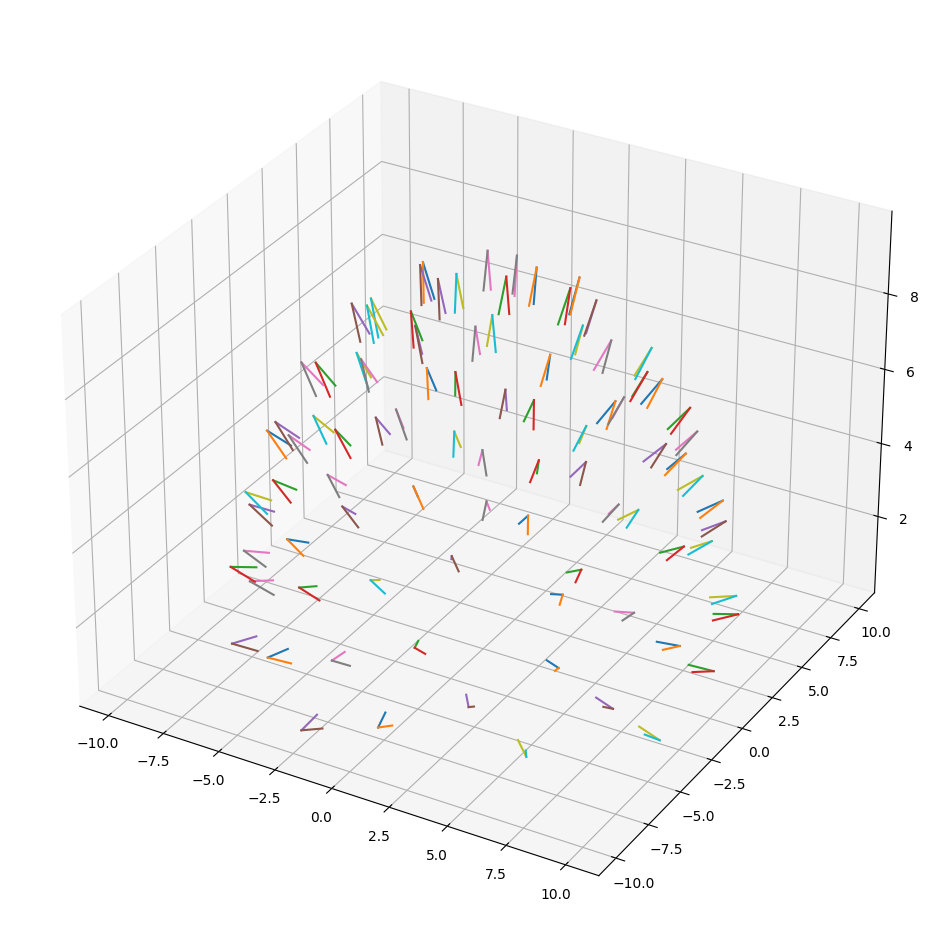

In [6]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
t = 1

for i in range(train_rd.shape[0]):
    o = train_ro[i]
    d = train_rd[i]
    pt1 = o
    pt2 = o+t*d
    show1 = np.vstack((pt1[0],pt1[-1]))
    show2 = np.vstack((pt2[0],pt2[-1]))
    for p1,p2 in zip(show1, show2):
        ax.plot([p1[0],p2[0]],
                [p1[1],p2[1]],
                [p1[2],p2[2]])
        
plt.show()

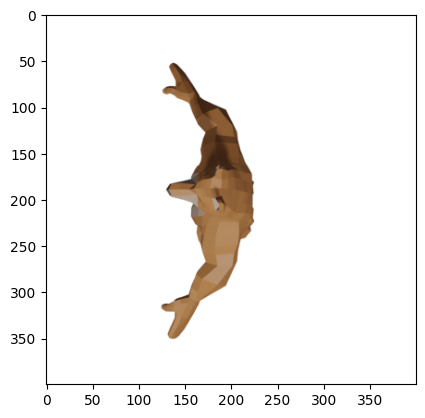

In [7]:
plt.imshow(train_imgs[0].reshape(400,400,3))
plt.show()

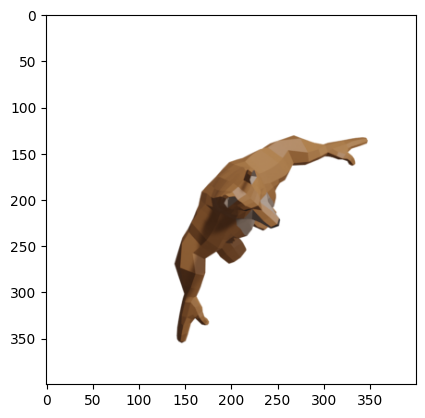

In [8]:
plt.imshow(train_imgs[1].reshape(400,400,3))
plt.show()

In [9]:
dataloader = DataLoader(
    torch.cat((torch.from_numpy(train_ro).reshape(-1,3),
              torch.from_numpy(train_rd).reshape(-1,3),
              torch.from_numpy(train_imgs).double().reshape(-1,3)),dim=1),
    batch_size=batch_size,
    shuffle=True
)

In [10]:
def rendering(model, rays_o, rays_d, 
              tn: Union[float,int], 
              tf: Union[float,int], 
              nb_bins:int=100, 
              device:str='cpu',
              white_bg=True):
    
    t = torch.linspace(tn, tf, nb_bins).to(device)
    delta = torch.cat((t[1:]-t[:-1], torch.tensor([1e10]).to(device)))
    r = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1)*rays_d.unsqueeze(1) 
    colors, density = model.intersect(r.reshape(-1,3))
    colors = colors.reshape((r.shape[0], nb_bins, 3))
    density = density.reshape((r.shape[0], nb_bins))
    # [nb_rays, nb_bins]
    alpha = 1-torch.exp(-density*delta.unsqueeze(0)) 
    T = torch.cumprod(1-alpha, 1) # [nb_rays, nb_bins]
    T = torch.cat((torch.ones(T.shape[0],1,device=T.device),
                  T[:,:-1]), dim=1)
    T = T*alpha
    if white_bg:
        c = (T.unsqueeze(-1)*colors).sum(1) 
        weight_sum = T.sum(-1)
        return c + 1-weight_sum.unsqueeze(-1)
    else:
        c = (T.unsqueeze(-1)*colors).sum(1) 

    return c

- Condition for a voxel (cube)
$$
\big\{x|x\in (-\frac{s}{2},\frac{s}{2})\big\} \cap \big\{y|y\in (-\frac{s}{2},\frac{s}{2})\big\} \cap \big\{z|z\in (-\frac{s}{2},\frac{s}{2})\big\}
$$

In [11]:
class Voxels(nn.Module):
    def __init__(self, 
        nb_voxels=100,
        device='cpu',
        scale=1
    ):
        super(Voxels, self).__init__()
        # 4=rgb and density
        self.voxels = nn.Parameter(
                torch.rand((nb_voxels, nb_voxels, nb_voxels, 4),
                device=device, requires_grad=True))
        self.nb_voxels = nb_voxels
        self.device = device
        self.scale = scale
        
    def forward(self, r):
        x = r[:,0]
        y = r[:,1]
        z = r[:,2]
        
        cond = (x.abs() < (self.scale/2)) & \
            (y.abs() < (self.scale/2)) & \
            (z.abs() < (self.scale/2))
        
        ix = (x[cond]/(self.scale/self.nb_voxels) + self.nb_voxels/2).type(torch.long)
        iy = (y[cond]/(self.scale/self.nb_voxels) + self.nb_voxels/2).type(torch.long)
        iz = (z[cond]/(self.scale/self.nb_voxels) + self.nb_voxels/2).type(torch.long)

        colors_and_densities = torch.zeros((r.shape[0],4), device=r.device)
        colors_and_densities[cond, :3] = self.voxels[ix,iy,iz,:3]
        colors_and_densities[cond, -1] = self.voxels[ix,iy,iz,-1]
        
        return torch.sigmoid(colors_and_densities[:, :3]), torch.relu(colors_and_densities[:, -1:])
    
    def intersect(self, x):
        return self.forward(x)

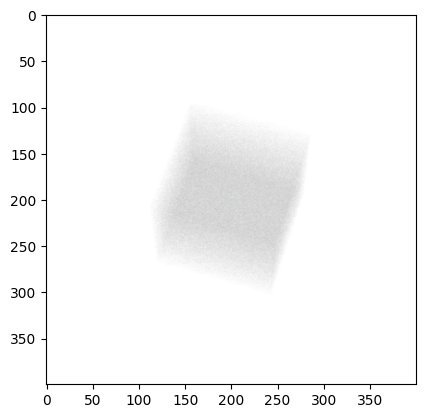

In [12]:
angle_i = 11
model = Voxels(scale=1)
img = rendering(model, 
    torch.from_numpy(train_ro[angle_i]),
    torch.from_numpy(train_rd[angle_i]),
    8, 12)
plt.imshow(img.reshape(400,400,3).data.cpu().numpy())
plt.show()

In [13]:
model = Voxels(scale=3, device=device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, 
        milestones=[5,10], gamma=gamma)

In [ ]:
training_loss = []
for epoch in range(num_epochs):
    print(f"[INFO] Epoch {epoch+1} ... ")
    for _, batch in enumerate(tqdm(dataloader)):
        o = batch[:, :3].to(device)
        d = batch[:, 3:6].to(device)
        target = batch[:, 6:].to(device)
        
        pred = rendering(model, o, d, tn, tf, 
                nb_bins=nb_bins, device=device)
        loss = ((pred-target)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        training_loss.append(loss.item())
        
    scheduler.step()
    torch.save(model.cpu(), 'model_nerf')
    model.to(device)


  0%|          | 0/7032 [00:00<?, ?it/s]

[INFO] Epoch 1 ... 


100%|██████████| 7032/7032 [02:55<00:00, 40.09it/s]
/home/yui/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Voxels. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
  0%|          | 0/7032 [00:00<?, ?it/s]

[INFO] Epoch 2 ... 


 17%|█▋        | 1221/7032 [00:33<02:23, 40.43it/s]

In [ ]:
torch.cuda.empty_cache()
model = torch.load('model_voxels')
model.eval()
for param in model.parameters():
    param.requires_grad = False
device = 'cuda'
angle_i = 1
with torch.no_grad():
    img = rendering(model.to(device),
            torch.from_numpy(train_ro[angle_i]).to(device),
            torch.from_numpy(train_rd[angle_i]).to(device),
            tn, tf, nb_bins=100, device=device,
            white_bg=True)
    plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())
    plt.show()